generate $S_t$

In [7]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(8)  # 设置固定的随机数种子


# def brownian_motion(N, T):
#     """
#     模拟布朗运动
#     N : 分区数量
#     T : 总时间
#     h : 时间步长
#     """
#     dt = T/N
#     t = np.linspace(0, T, N)
#     W = np.zeros(N)
#     W[1:] = np.cumsum(np.random.standard_normal(size=N-1)) * np.sqrt(dt)  # 累积和
#     return t, W


def St_motion(N, T, S0, r, l, sigma):
    """
    模拟股票的随机过程
    N : 分区数量
    T : 总时间
    h : 时间步长
    """
    dt = T/N
    t = np.linspace(0, T, N)
    W = np.zeros(N)
    lgSt = np.zeros(N)
    W[1:] = np.cumsum(np.random.standard_normal(size=N-1)) * np.sqrt(dt)  # 累积和
    lgSt[1:] = (r - l - 0.5 * sigma**2) * t[1:] + sigma * W[1:]
    St = S0*np.exp(lgSt)
    return t, St

compute the integral of generated oracle.

In [8]:

def trapezoidal_rule(t, W):
    """
    使用梯形法则计算积分
    t : 时间数组
    W : 位置数组
    """
    dt = np.diff(t)
    integral = np.sum(0.5 * dt * (W[:-1] + W[1:]))
    return integral


In [9]:
import numpy as np
from scipy.optimize import minimize

np.random.seed(8)  # 设置随机种子

def MC(M, x0, T0, lifespan, l):
    '''
    M : 蒙特卡洛模拟次数
    x0 : 投保的年龄
    T0 : 投保的公元年份
    lifespan : 预期最长的寿命
    l : 死亡率
    '''
    T = lifespan - x0
    annu_day = 252
    buff_day = 10
    N = annu_day * buff_day
    S0 = 1.0
    r = 0.06
    g = 0
    sigma = 0.2
    lamda = 1.0/35.0

    result = []
    avg_res = []
    fee_result = []
    fee_avg_res = []


    for i in range(1, M+1):
        t_all, S_t = St_motion(N, T, S0, r, l, sigma)
        final_int = lamda * np.exp(-(lamda+r) * t_all) * np.maximum(np.exp(g * t_all)- S_t, 0)
        integral = trapezoidal_rule(t_all, final_int)
        integral += np.exp(-lamda*T) * np.exp(-r*T)*np.maximum(np.exp(g*T)-S_t[-1],0)

        single_V = np.exp(-l*t_all)*lamda*np.exp(-lamda*t_all)
        int_death_payoff = trapezoidal_rule(t_all, single_V)
        fee = 1 - int_death_payoff - np.exp(-lamda*T)*np.exp(-l*T)

        fee_result.append(fee)
        result.append(integral)
        avg_res = np.mean(result)
        fee_avg_res = np.mean(fee_result)
    
    return avg_res, fee_avg_res



In [17]:
def preliminary_search(M, x0, T0, lifespan, S0, initial_l, max_iter=100):
    l = initial_l
    step_size = 0.00004  # 初始步长，可调整
    lower_l, upper_l = None, None  # 初始化 lower_l 和 upper_l

    # 首先减小 l 直到 fee_avg_res - avg_res[-1] 变为负值
    for i in range(max_iter):
        avg_res, fee_avg_res = MC(M, x0, T0, lifespan, l)
        print("l: ", l)
        print("max(exp(g*t), S_t): ", avg_res)
        print("fee_avg_res: ", fee_avg_res)
        difference = fee_avg_res - avg_res
        if difference < 0:
            upper_l = l + step_size  # 记录这个点的前一个点为 upper_l
            break
        l -= step_size

    # 从取负值的 l 开始，反转方向，以较小的步长增加 l
    step_size /= 4  # 减小步长
    for i in range(max_iter):
        l += step_size
        avg_res, fee_avg_res = MC(M, x0, T0, lifespan, l)
        print("l: ", l)
        print("max(exp(g*t), S_t): ", avg_res)
        print("fee_avg_res: ", fee_avg_res)
        difference = fee_avg_res - avg_res
        if difference > 0:
            lower_l = l - step_size  # 记录这个点的前一个点为 lower_l
            break

    return lower_l, upper_l


def fine_search(M, x0, T0, lifespan, S0, lower_l, upper_l, fine_step_size):
    best_l = lower_l
    min_difference = np.inf
    found_small_diff = False  # 标记是否找到小于0.0003的差异
    
    l = lower_l
    while l <= upper_l:
        avg_res, fee_avg_res = MC(M, x0, T0, lifespan, l)
        print("l: ", l)
        print("max(exp(g*t), S_t): ", avg_res)
        print("fee_avg_res: ", fee_avg_res)
        difference = abs(fee_avg_res - avg_res)  # 计算差值的绝对值
        
        # 如果找到了小于0.0003的差异，标记为True
        if difference < 0.0005:
            found_small_diff = True
        
        # 在找到小于0.0003的差异后，如果差异又大于0.0025，结束搜索
        if found_small_diff and difference > 0.0025:
            print(f"Ending search: difference increased beyond 0.0025 after finding a smaller difference.")
            break  # 结束循环
        
        # 更新最小差异和最优l
        if difference < min_difference:
            min_difference = difference
            best_l = l
            
        l += fine_step_size  # 使用非常小的步长
    
    print(f"Best l before stopping: {best_l}, Min difference before stopping: {min_difference}")
    return best_l, min_difference



# 初始化参数
M = 100000
x0 = 50
T0 = 2020
lifespan = 250
S0 = 1.0
initial_l = 0.0006  # 初始l值
tolerance = 1e-6  # 容忍度

# 初步搜索
lower_l, upper_l = preliminary_search(M, x0, T0, lifespan, S0, initial_l)
print("lower_l, upper_l", lower_l, upper_l)

if lower_l is not None and upper_l is not None:
    # 精细搜索
    fine_step_size = 0.000002  # 精细搜索步长
    best_l, min_difference = fine_search(M, x0, T0, lifespan, S0, lower_l, upper_l, fine_step_size)
    print(f"Best l value: {best_l} with minimum difference: {min_difference}")
else:
    print("Unable to find suitable l interval during preliminary search.")

l:  0.0006
max(exp(g*t), S_t):  0.021494949024169086
fee_avg_res:  0.02050746182290732
l:  0.00061
max(exp(g*t), S_t):  0.02167322132028507
fee_avg_res:  0.020842237311604925
l:  0.00062
max(exp(g*t), S_t):  0.021512634539692037
fee_avg_res:  0.021176787191269923
l:  0.00063
max(exp(g*t), S_t):  0.02145721577545978
fee_avg_res:  0.021511111682186997
lower_l, upper_l 0.00062 0.0006399999999999999
l:  0.00062
max(exp(g*t), S_t):  0.021742597316320025
fee_avg_res:  0.021176787191269923
l:  0.000622
max(exp(g*t), S_t):  0.021535494584076928
fee_avg_res:  0.021243670113509132
l:  0.0006240000000000001
max(exp(g*t), S_t):  0.02156773495214034
fee_avg_res:  0.021310544021959803
l:  0.0006260000000000001
max(exp(g*t), S_t):  0.021594923226221717
fee_avg_res:  0.021377408918383294
l:  0.0006280000000000002
max(exp(g*t), S_t):  0.02138078447818593
fee_avg_res:  0.02144426480453918
l:  0.0006300000000000002
max(exp(g*t), S_t):  0.021483282210600797
fee_avg_res:  0.021511111682186997
l:  0.0006320

np.maximum(np.exp(g * t_all), S_t): 0.03616758366396949
fee_avg_res: 0.19534372590917573


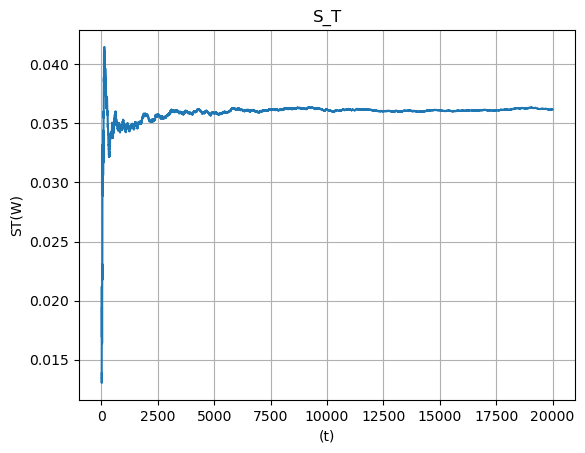

In [33]:
N = 200000    # 划分的区间数量
T =  25 # 积分时长
S0 = 1.0      # 初始资产价格
r = 0.06    # 风险无关利率
l = 0.0125  # 风险费率
sigma = 0.2 # 波动率
dt = T/N    # 时间步长
lamda = 1.0/35.0
g = 0
M = 20000  # MC次数

result = []
avg_res = []
fee_result = []
fee_avg_res = []

for i in range(1, M+1):
    t_all, S_t = St_motion(N, T, S0, r, l, sigma)
    final_int = lamda * np.exp(-(lamda+r) * t_all) * np.maximum(np.exp(g * t_all)-S_t, 0)
    integral = trapezoidal_rule(t_all, final_int)
    integral += np.exp(-lamda*T) * np.exp(-r*T)*np.maximum(np.exp(g*T)-S_t[-1], 0)

    single_V = np.exp(-l*t_all)*lamda*np.exp(-lamda*t_all)
    int_death_payoff = trapezoidal_rule(t_all, single_V)
    fee = 1 - int_death_payoff - np.exp(-lamda*T)*np.exp(-l*T)
    # print("fee", fee)
    fee_result.append(fee)
    
    result.append(integral)
    avg_res.append(np.sum(result)/i)
    fee_avg_res.append(np.sum(fee_result)/i)
print("np.maximum(np.exp(g * t_all), S_t):", avg_res[-1])
print("fee_avg_res:", fee_avg_res[-1])


plt.plot(list(range(10, M+1)), avg_res[9:])
plt.title('S_T')
plt.xlabel('(t)')
plt.ylabel('ST(W)')
plt.grid(True)
plt.show()

# 0.021360249510229964   80 0.00063, 加上最后一个积分值
# 0.02199870073346169    80 0.00068, 加上最后一个积分值
# 0.021660506019570494   80 0.00070, 加上最后一个积分值
# 0.02704523691063785    80  0.01

# 1.0067350186952124     80  0.00070, np.maximum(np.exp(g * t_all),S_t)
# 1.0120532569294065     80  0.00050, np.maximum(np.exp(g * t_all),S_t)
# 1.0088805903696871     80  0.00030, np.maximum(np.exp(g * t_all),S_t)
# 1.017241830240269      80  0.00050, np.maximum(np.exp(g * t_all),S_t)

# 0.02153302072244826    80  0.00050, np.maximum(np.exp(g * t_all)-S_t)
# np.maximum(np.exp(g * t_all), S_t): 0.03581602801263688, 63000
# np.maximum(np.exp(g * t_all), S_t): 0.03561059683256578, 63000
# np.maximum(np.exp(g * t_all), S_t): 0.03586030816244619, 63000
# np.maximum(np.exp(g * t_all), S_t): 0.03671884144143862, 63000
# np.maximum(np.exp(g * t_all), S_t): 0.036024259630258584, 100000
# np.maximum(np.exp(g * t_all), S_t): 0.03600298953503484, 200000
# np.maximum(np.exp(g * t_all), S_t): 0.03634995049883398, 200000
# np.maximum(np.exp(g * t_all), S_t): 0.03616758366396949, 200000
# np.maximum(np.exp(g * t_all), S_t): 0.0359644781785514, 300000



In [21]:
import scipy.integrate as spi
import numpy as np
l = 0.0125  # 风险费率
T =  25 # 积分时长
lamda = 1.0/35.0

def f(t):
    single_V = np.exp(-l*t)*lamda*np.exp(-lamda*t)
    return single_V

results = []
errors = []
def int_death_payoff(f):
    result, error = spi.quad(f, 0, T)  # 从0积分到T
    return result

def fee(T):
    # fee = 1 - int_death_payoff(f)
    fee = 1 - int_death_payoff(f) - np.exp(-lamda*T)*np.exp(-l*T)
    return fee

fee(T)

# 0.021574286972256922  0.00063 T = 1000
# 0.019487995860379262  0.00063 T = 80
# 0.021007681389254643  0.00068  T = 80
# 0.021614460867100505  0.00070  T = 80
# 0.01551843890488705   0.00050  T = 80

# 0.030641664136211597     0.001  T = 80
# 0.24741179004543104      0.01  T = 80
# 0.20383754787469324      0.01  T = 40

0.19534372591015653

In [1]:
ax_path = "./data/lc_ax_female(1).csv"
bx_path = "./data/lc_bx_female(1).csv"
kt_path = "./data/lc_kt_female(1).csv"
path = [ax_path, bx_path, kt_path]

import Prob 
death_Prob = Prob.D_Prob()
death_Prob.read_abk(path)

import scipy.integrate as spi
import numpy as np

l = 0.00063  # 风险费率
annu_day = 1

def fee(x0, T0, T):
    for i in range(0, (T-x0)*annu_day):#
        # print(i)
        fee_death = 0
        fee_death += np.exp(-l*(i+1)/annu_day) * death_Prob.gen_P(x0, T0, i//annu_day +1)/annu_day
    fee = 1 - fee_death - death_Prob.accu_live(x0, T0, (T-x0))*np.exp(-l*(T-x0))

    return fee

fee(50, 2020, 80)

/home/hhf/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


指数方法死亡概率 0.0015227932268011557
对比的死亡概率 0.0015227935212924898
指数方法死亡概率 0.0015955748666667269
对比的死亡概率 0.0015955752054462448
指数方法死亡概率 0.001712665613716191
对比的死亡概率 0.0017126660327111164
指数方法死亡概率 0.0018173082301226051
对比的死亡概率 0.0018173087307326932
指数方法死亡概率 0.0019433803197963506
对比的死亡概率 0.0019433809320263317
指数方法死亡概率 0.0020724241827765333
对比的死亡概率 0.002072424925291556
指数方法死亡概率 0.0022142709922454706
对比的死亡概率 0.002214271897962422
指数方法死亡概率 0.00236205672235279
对比的死亡概率 0.0023620578218732156
指数方法死亡概率 0.0025185700057720473
对比的死亡概率 0.002518571338766923
指数方法死亡概率 0.0026824186836865715
对比的死亡概率 0.00268242029426472
指数方法死亡概率 0.0028566397483136274
对比的死亡概率 0.0028566416937026934
指数方法死亡概率 0.0030440211586383326
对比的死亡概率 0.0030440235127326297
指数方法死亡概率 0.0032492935874780526
对比的死亡概率 0.0032492964509468836
指数方法死亡概率 0.003476946100723244
对比的死亡概率 0.0034769496096077844
指数方法死亡概率 0.00373138437059517
对比的死亡概率 0.0037313887081067464
指数方法死亡概率 0.004016009280604971
对比的死亡概率 0.0040160146891054785
指数方法死亡概率 0.004333483920274994
对比的死亡概

0.5913869613038203

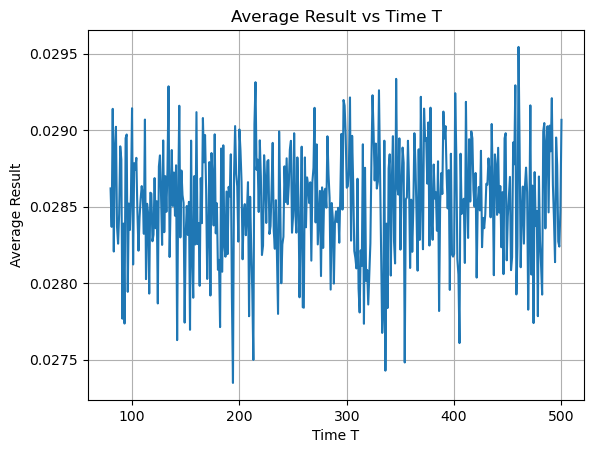

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 定义St_motion和trapezoidal_rule函数
# 这里需要您提供这两个函数的具体实现
def St_motion(N, T, S0, r, l, sigma):
    """
    模拟股票的随机过程
    N : 分区数量
    T : 总时间
    h : 时间步长
    """
    dt = T/N
    t = np.linspace(0, T, N)
    W = np.zeros(N)
    lgSt = np.zeros(N)
    W[1:] = np.cumsum(np.random.standard_normal(size=N-1)) * np.sqrt(dt)  # 累积和
    lgSt[1:] = (r - l - 0.5 * sigma**2) * t[1:] + sigma * W[1:]
    St = S0*np.exp(lgSt)
    return t, St


def trapezoidal_rule(t, W):
    """
    使用梯形法则计算积分
    t : 时间数组
    W : 位置数组
    """
    dt = np.diff(t)
    integral = np.sum(0.5 * dt * (W[:-1] + W[1:]))
    return integral

# 参数
N = 200000    # 划分的区间数量
S0 = 1.0      # 初始资产价格
r = 0.06      # 风险无关利率
l = 0.0125    # 风险费率
sigma = 0.2   # 波动率

lamda = 1.0/35.0
g = 0
M = 10000     # MC次数

T_values = range(80, 501)  # T的值从80到500
avg_results = []

for T in T_values:
    dt = T / N  # 时间步长
    result = []
    for i in range(1, M + 1):
        t_all, S_T = St_motion(N, T, S0, r, l, sigma)
        final_int = lamda * np.exp(-(lamda + r) * t_all) * np.maximum(np.exp(g * t_all) - S_T, 0)
        integral = trapezoidal_rule(t_all, final_int)
        result.append(integral)
    avg_res = np.sum(result) / M
    avg_results.append(avg_res)

# 绘制图表
plt.plot
plt.plot(T_values, avg_results)
plt.title('Average Result vs Time T')
plt.xlabel('Time T')
plt.ylabel('Average Result')
plt.grid(True)
plt.show()


In [ ]:
avg_results

[0.028618417275593482,
 0.028367246511340927,
 0.02913852778898705,
 0.02820593440530688,
 0.028889824089426714,
 0.02902117507060218,
 0.028367909010048844,
 0.0282572180091272,
 0.02845293279829479,
 0.028893380833001834,
 0.028807991398271678,
 0.02776700592633082,
 0.02838859396613252,
 0.027735190304212266,
 0.028946907292782122,
 0.028970663993776975,
 0.027942474536643686,
 0.028519754118411594,
 0.028346791064794888,
 0.02858021009940913,
 0.029142326778199664,
 0.02812119983346813,
 0.02878318966590103,
 0.028741141163292985,
 0.028818257011126763,
 0.028462566513190235,
 0.028211516688661384,
 0.028427322134574332,
 0.028548957221911076,
 0.028633487985664577,
 0.02857528235484053,
 0.028321747626983456,
 0.029068424055557443,
 0.028025713743864127,
 0.028518124711778926,
 0.028453095148637583,
 0.027930982590399656,
 0.028590211249320895,
 0.028584945161602218,
 0.028273154580488097,
 0.028316398203904983,
 0.028685811902219728,
 0.02835860435277929,
 0.028534653755143215,
 

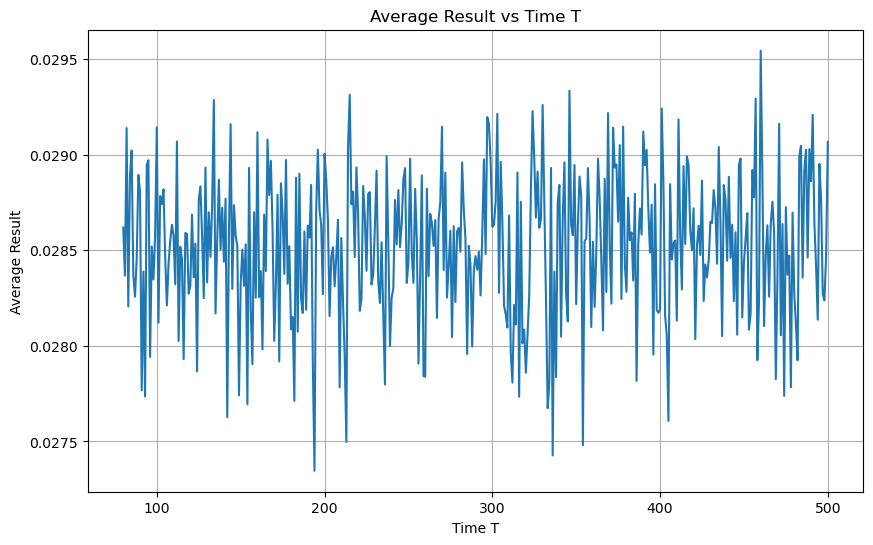

In [ ]:

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(T_values, avg_results)
plt.title('Average Result vs Time T')
plt.xlabel('Time T')
plt.ylabel('Average Result')
plt.grid(True)
plt.show()